FZGMtwsXkAEmY4x.jpg


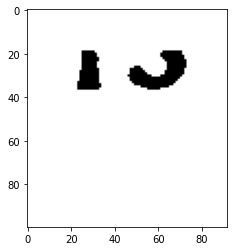

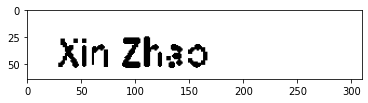

Xin Zhao



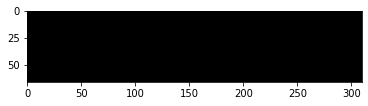

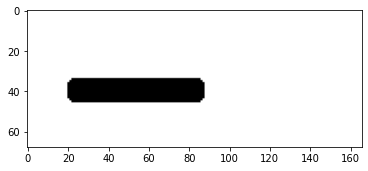

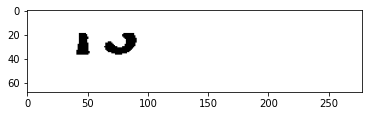


//


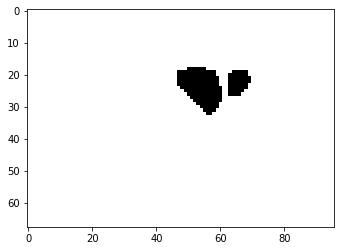

FZGMtwsXkAEmY4x.jpg


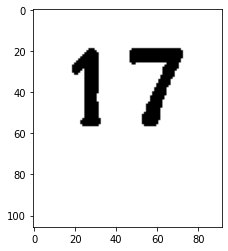

17



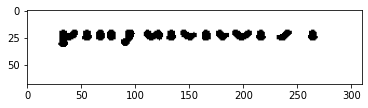

seey wswervss 2



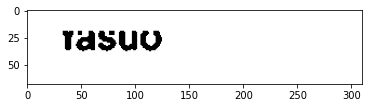

Tasugo



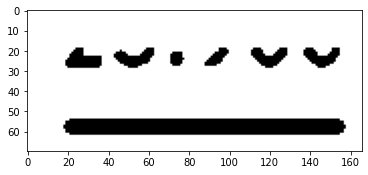

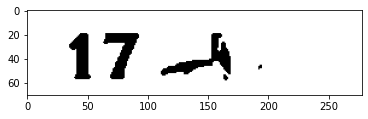

17

7
7



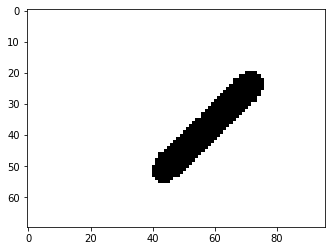

FZGMtwsXkAEmY4x.jpg


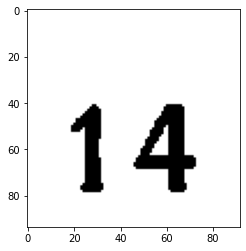

14



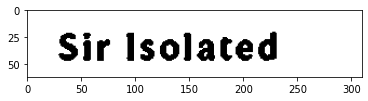

Sir Isolated



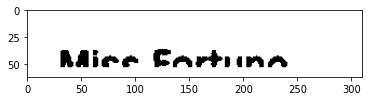

Mies Earhina



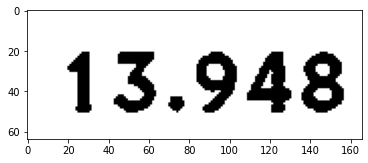

13948



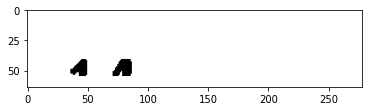

4

/



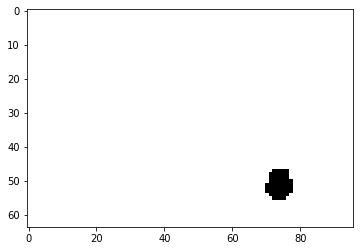

FZGMtwsXkAEmY4x.jpg


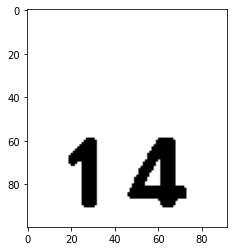

14



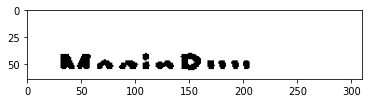

RA anion Deuves



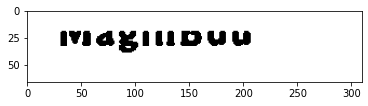

MmayiipbUU



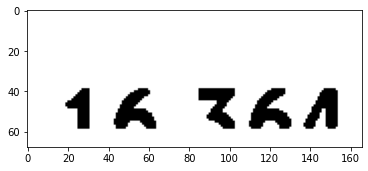

1



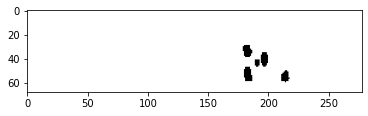

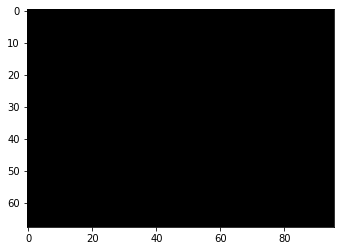

FZGMtwsXkAEmY4x.jpg


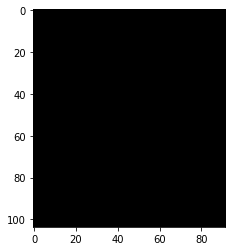

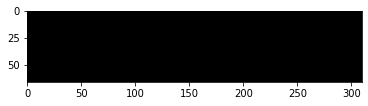

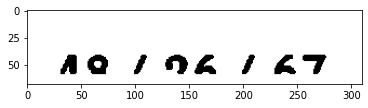

AQ /Nh /4T



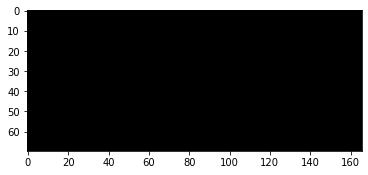

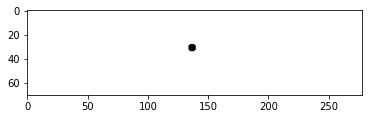

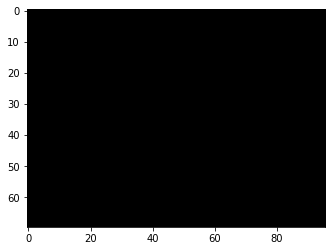

FZGMtwsXkAEmY4x.jpg


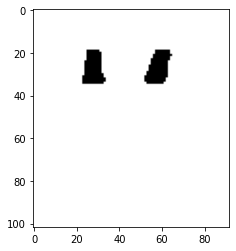

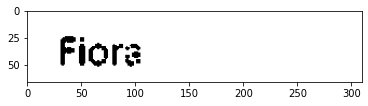

Fiore



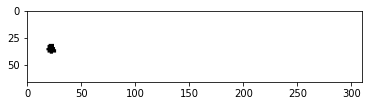

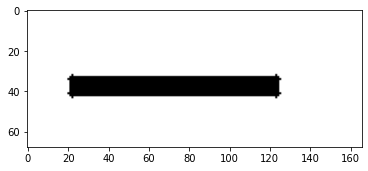

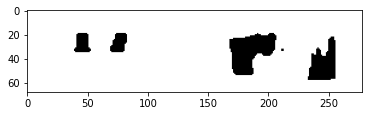


/



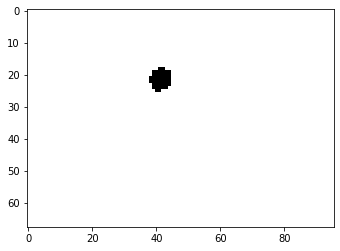

FZGMtwsXkAEmY4x.jpg


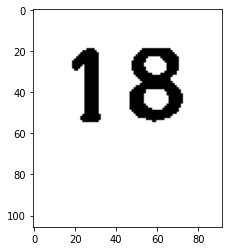

18



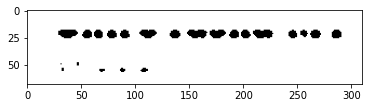

were ewwcew even



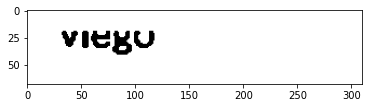

vicgU



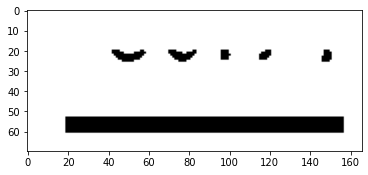

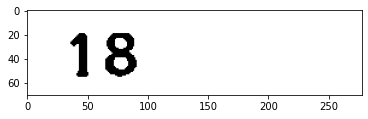

18

///



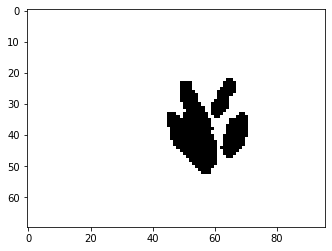

FZGMtwsXkAEmY4x.jpg


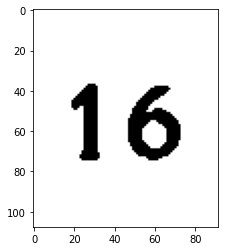

16



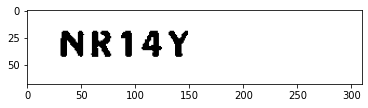

NR14Y



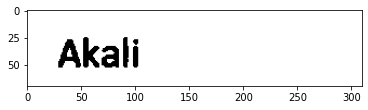

Akali



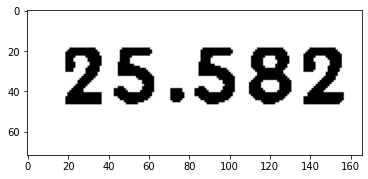

25582



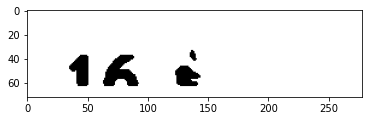

1

/
4



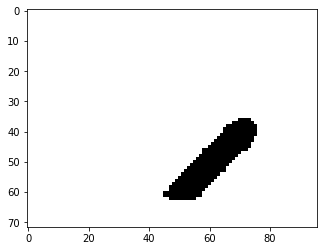

FZGMtwsXkAEmY4x.jpg


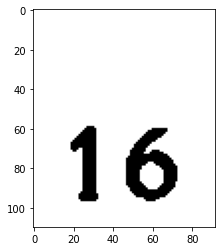

16



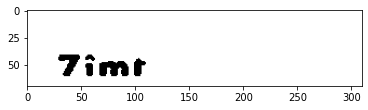

Timer



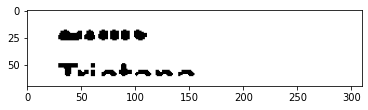

Fenton



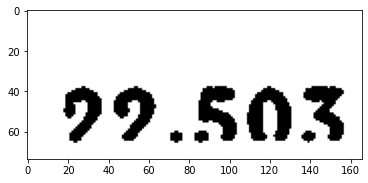

99803



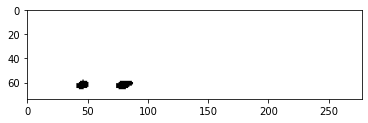

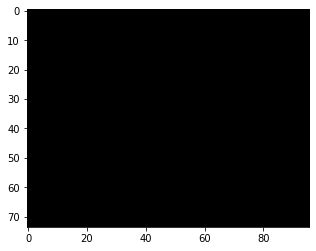

FZGMtwsXkAEmY4x.jpg


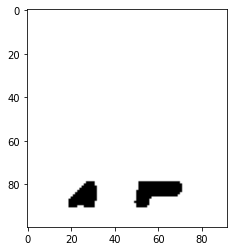

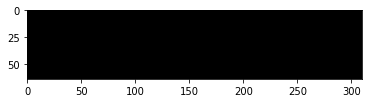

Be



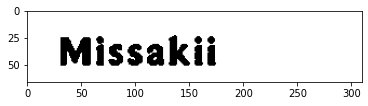

Missakii



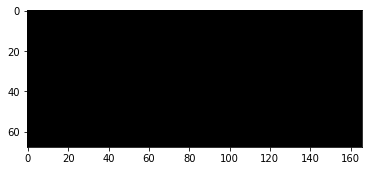

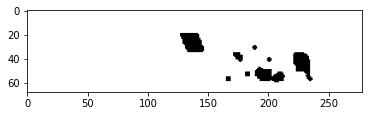

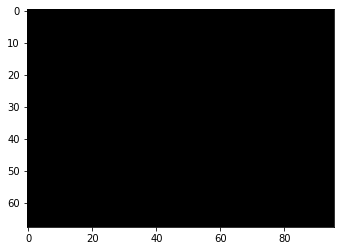

FZGMxbqXEAIkzqS.jpg


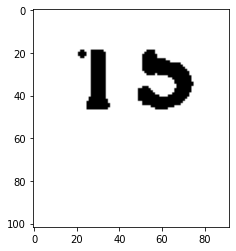

1



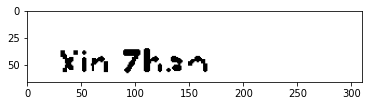

Xin 7haa



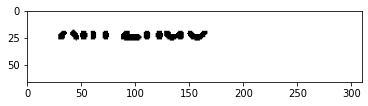

oe Od



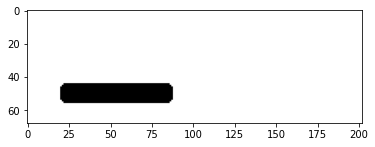

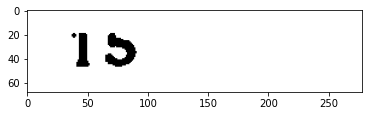

1

///



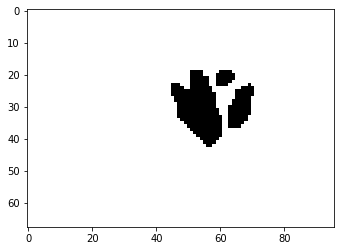

FZGMxbqXEAIkzqS.jpg


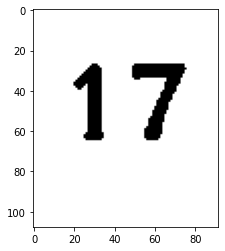

17



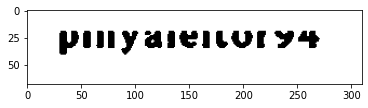

Pilly aielLuly4+



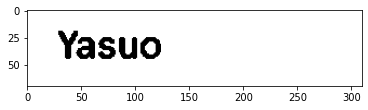

Yasuo



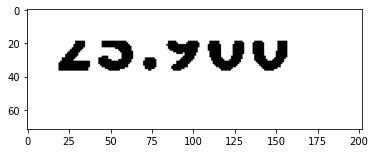

97



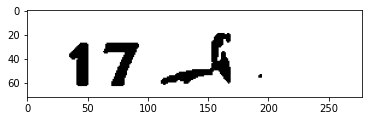

174

7
/



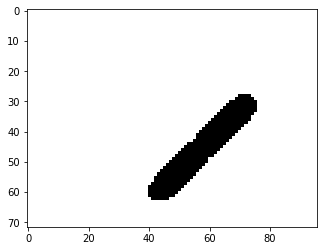

FZGMxbqXEAIkzqS.jpg


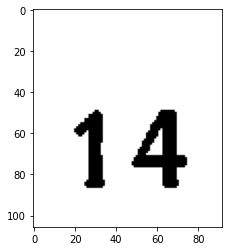

14



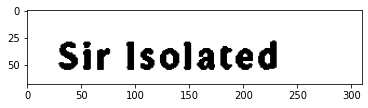

Sir Isolated



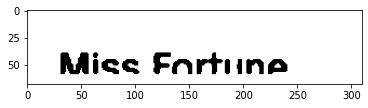

Mice Fartine



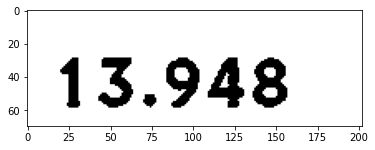

13948



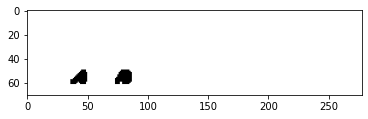

4

/



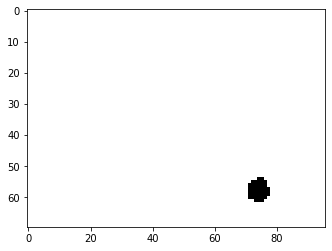

FZGMxbqXEAIkzqS.jpg


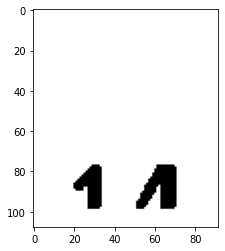

1



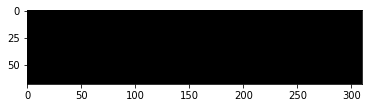

OS



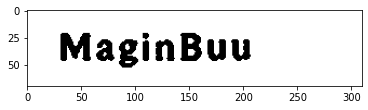

MaginBuu



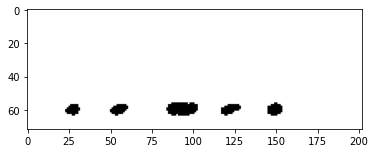

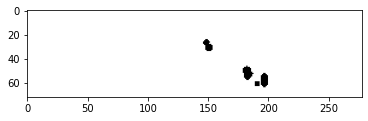

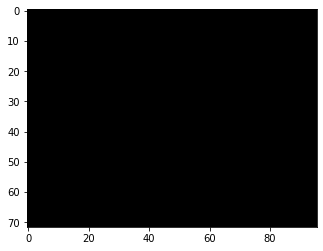

FZGMxbqXEAIkzqS.jpg


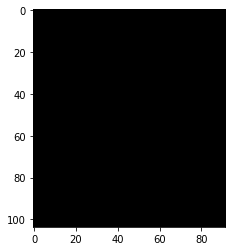

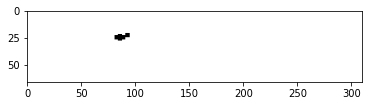

-



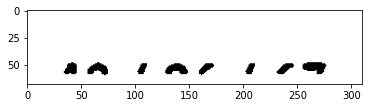

an t+mertere



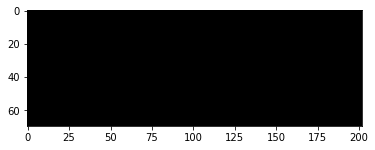

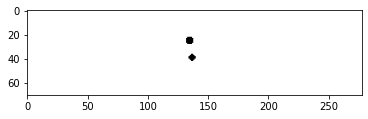

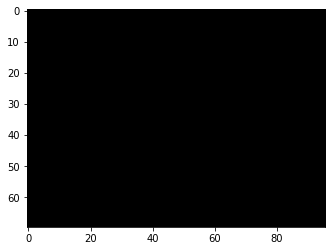

FZGMxbqXEAIkzqS.jpg


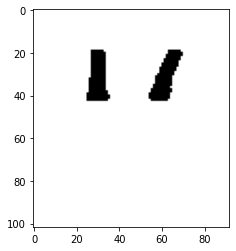

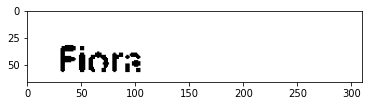

Fiors



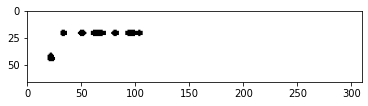

oomee



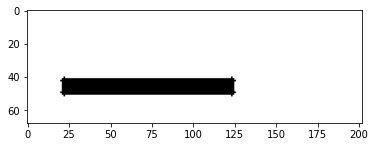

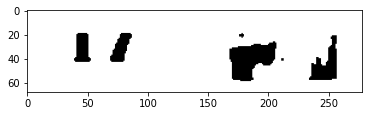


/



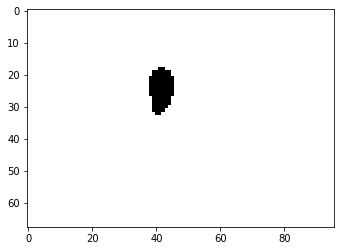

FZGMxbqXEAIkzqS.jpg


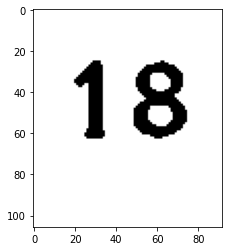

18



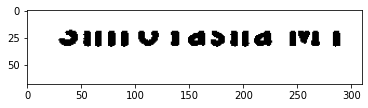

Su Viasia ime



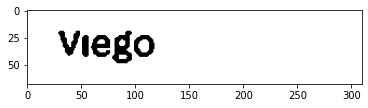

viego



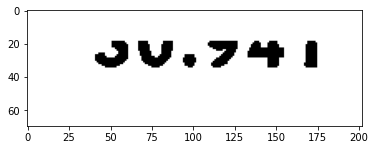

741



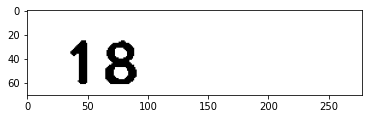

18

///



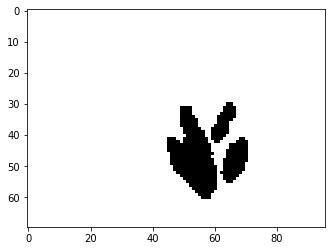

FZGMxbqXEAIkzqS.jpg


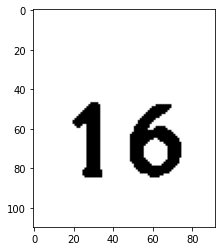

16



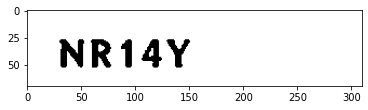

NR14Y



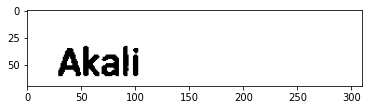

Akali



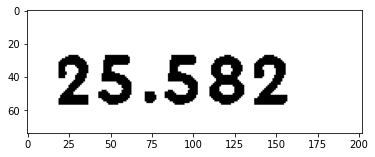

25582



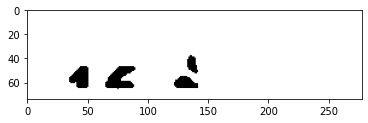

4

/



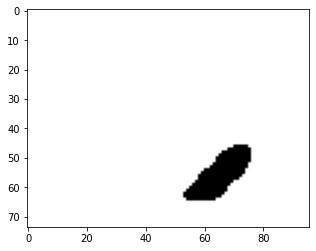

FZGMxbqXEAIkzqS.jpg


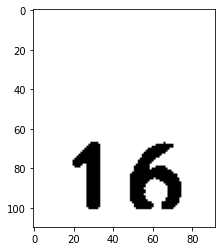

16



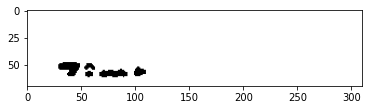

Fiano



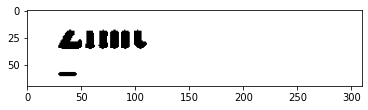

eum



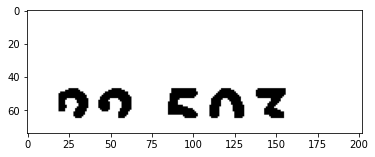

99



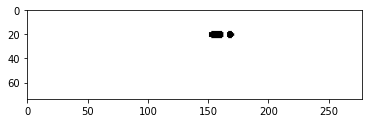

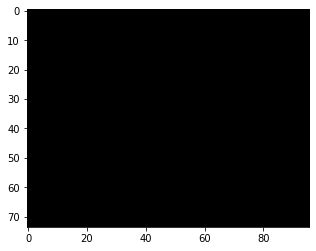

FZGMxbqXEAIkzqS.jpg


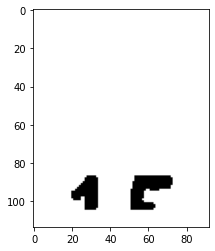

4



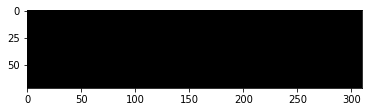

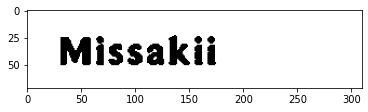

Missakii



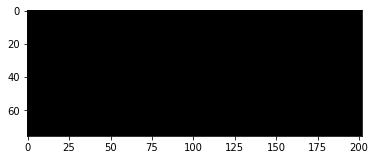

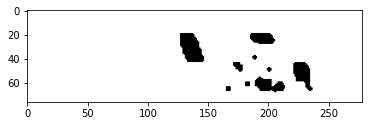

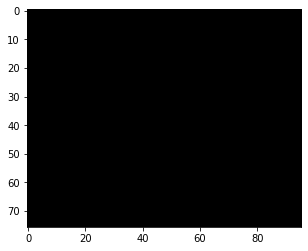

FZkWYF1XwAA5pda.jpg


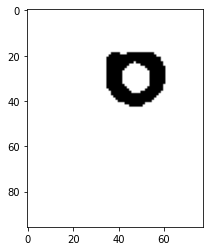

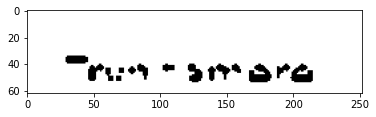

Trt * ort ere



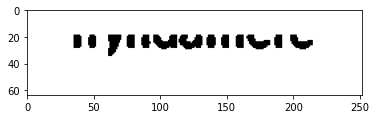

BO Peeneeriwiy



error: OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from os import walk, remove
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract'

%matplotlib inline

files = next(walk('./input'), (None, None, []))[2]  # [] if no file
outputFiles = next(walk('./output'), (None, None, []))[2]  # [] if no file
for outputFile in outputFiles:
    remove('./output/' + outputFile)


def filterFunction(cnt, image):
    x, y, w, h = cv2.boundingRect(cnt)
    if h > (image.shape[0] / 2) and w < (image.shape[1] / 5) and x > (3 * image.shape[1] / 4):
        return True
    return False

def filterFunction2(cnt, image):
    x, y, w, h = cv2.boundingRect(cnt)
    if h > (image.shape[0] / 30):
        return True
    return False

def readText(image):
    data = pytesseract.image_to_string(image, config='--oem 3 --psm 6 -c tessedit_char_whitelist=0123456789')
    return data

def readTextUsernameAndChampion(image):
    data = pytesseract.image_to_string(image, config='--oem 3 --psm 7')
    return data

def readText2(image):
    data = pytesseract.image_to_string(image, config='--psm 7 --oem 3 -c tessedit_char_whitelist=0123456789')
    return data

def readText3(image):
    data = pytesseract.image_to_string(image, config='--psm 10 -c tessedit_char_whitelist=0123456789/')
    return data

def readText4(image):
    data = pytesseract.image_to_string(image, config='--psm 7 -c tessedit_char_whitelist=0123456789/')
    return data


def getLvlCoords(imgs):
    lvlCoords = []
    for img in imgs:
        img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        image_enhanced = cv2.equalizeHist(img_gray)
        thresh = 225
        im_bw = cv2.threshold(img_gray, thresh, 255, cv2.THRESH_BINARY)[1]
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
        dilate = cv2.dilate(im_bw, kernel, iterations=3)
        
        cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]
        cnts = filter(lambda item: cv2.contourArea(item) > 300, cnts)
        cnts = sorted(cnts, key=lambda item1: item1[0][0][0])

        if(len(cnts) > 2):
            for i in range(0, 2):
                x, y, w, h = cv2.boundingRect(cnts[i])
                x2, y2, w2, h2 = cv2.boundingRect(cnts[i + 1])
                if(x2 - (x + w) > 50):
                    break
                    
        elif(len(cnts) == 1):
            x, y, w, h = cv2.boundingRect(cnts[0])


        else:
            continue
        
        if(x > img.shape[1] / 7):
            continue
        
        if((w / h) > 1.25):
            x = int((x + w) - h * 1.25)
            w = int(h * 1.25)

            
        lvlCoords.append([x, y, w, h])
        
    i = 0
    lvlCoords2 = []
    for x, y, w, h in lvlCoords:
        for y in range(i + 1, len(lvlCoords)):
            x2, y2, w2, h2 = lvlCoords[y]
            if(abs((x + w) - (x2 + w2)) < 30):
                lvlCoords2.append([x, y, w, h])
                break
        i += 1
    x, y, w, h = 0, 0, 0, 0
    for x2, y2, w2, h2 in lvlCoords2:
        x += x2
        y += y2
        w += w2
        h += h2
                                     
    if(len(lvlCoords2) != 0):
        x /= len(lvlCoords2)
        y /= len(lvlCoords2)
        w /= len(lvlCoords2)
        h /= len(lvlCoords2)
        
    
    return int(x), int(y), int(w), int(h)


def getUsernameCoords(imgs, x_lvl):
    lvlCoords = []
    for img in imgs:
        img = img[:, x_lvl:]
        img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        image_enhanced = cv2.equalizeHist(img_gray)
        thresh = 225
        im_bw = cv2.threshold(img_gray, thresh, 255, cv2.THRESH_BINARY)[1]
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
        dilate = cv2.dilate(im_bw, kernel, iterations=3)
        
        cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]
        cnts = filter(lambda item: cv2.contourArea(item) > 300, cnts)
        cnts = sorted(cnts, key=lambda item1: item1[0][0][0])

        if(len(cnts) > 2):
            for i in range(0, 2):
                x, y, w, h = cv2.boundingRect(cnts[i])
                x2, y2, w2, h2 = cv2.boundingRect(cnts[i + 1])
                if(x2 - (x + w) > 50):
                    break
                    
        elif(len(cnts) == 1):
            x, y, w, h = cv2.boundingRect(cnts[0])


        else:
            continue
        
        if(x > img.shape[1] / 3):
            continue
            
        lvlCoords.append([x, y, w, h])
    i = 0
    lvlCoords2 = []
    for x, y, w, h in lvlCoords:
        for y in range(i + 1, len(lvlCoords)):
            x2, y2, w2, h2 = lvlCoords[y]
            if(abs(x - x2) < 30):
                lvlCoords2.append([x, y, w, h])
                break
        i += 1
    x, y, w, h = 0, 0, 0, 0
    for x2, y2, w2, h2 in lvlCoords2:
        x += x2
        y += y2
        w = w2 if w2 > w else w
        h += h2
                                     
    if(len(lvlCoords2) != 0):
        x /= len(lvlCoords2)
        y /= len(lvlCoords2)
        h /= len(lvlCoords2)
        
    
    return int(x), int(y), int(w), int(h)

def getGoldCoords(imgs):
    lvlCoords = []
    for img in imgs:
        img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        image_enhanced = cv2.equalizeHist(img_gray)
        thresh = 225
        im_bw = cv2.threshold(img_gray, thresh, 255, cv2.THRESH_BINARY)[1]
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
        dilate = cv2.dilate(im_bw, kernel, iterations=3)
        
        cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]
        cnts = filter(lambda item: cv2.contourArea(item) > 300, cnts)
        cnts = sorted(cnts, key=lambda item1: item1[0][0][0], reverse=True)

        if(len(cnts) > 1):
            x, y, w, h = cv2.boundingRect(cnts[0])


        else:
            continue
        
        if(x < 3 * img.shape[1] / 4):
            continue
            
        lvlCoords.append([x, y, w, h])
        
    i = 0
    lvlCoords2 = []
    for x, y, w, h in lvlCoords:
        for y in range(i + 1, len(lvlCoords)):
            x2, y2, w2, h2 = lvlCoords[y]
            if(abs((x + w) - (x2 + w2)) < 30):
                lvlCoords2.append([x, y, w, h])
                break
        i += 1
    x, y, w, h = 0, 0, 0, 0
    for x2, y2, w2, h2 in lvlCoords2:
        x = x2 if x2 > x else x
        w = w2 if w2 > w else w
                                         
    return int(x), int(y), int(w), int(h)


def getDmgCoords(imgs, x_gold):
    dmgCoords = []
    for img in imgs:
        if x_gold:
            img = img[:, :x_gold]
        img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        thresh = 225
        im_bw = cv2.threshold(img_gray, thresh, 255, cv2.THRESH_BINARY)[1]
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
        dilate = cv2.dilate(im_bw, kernel, iterations=3)
        
        cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]
        cnts = filter(lambda item: cv2.contourArea(item) > 300, cnts)
        cnts = sorted(cnts, key=lambda item1: item1[0][0][0], reverse=True)

        if(len(cnts) >= 1):
            x, y, w, h = cv2.boundingRect(cnts[0])
            dmgCoords.append([x, y, w, h])


        else:
            continue
        
        if(x < img.shape[1] * 0.75):
            continue
        
    i = 0
    dmgCoords2 = []
    for x, y, w, h in dmgCoords:
        for y in range(i + 1, len(dmgCoords)):
            x2, y2, w2, h2 = dmgCoords[y]
            
            if(abs((x + w) - (x2 + w2)) < 30):
                dmgCoords2.append([x, y, w, h])
                break
        i += 1

    x, y, w, h = 0, 0, 0, 0
    for x2, y2, w2, h2 in dmgCoords2:
        x = x2 if x2 < x or x == 0 else x
        w = w2 if w2 > w else w
        
                                         
    return int(x), int(y), int(w), int(h)


def preprocessImg(img):
    img=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    mask = img < 150
    img[mask] = 0
    img2 = cv2.copyMakeBorder(img, 10,5,10,5, borderType=cv2.BORDER_CONSTANT, value=0)
    img2 = cv2.equalizeHist(img2)
    img2 = cv2.bilateralFilter(img2,4,25, 25)
    img2 = cv2.resize(img2, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
    img2 = cv2.GaussianBlur(img2, (3, 3), 0)
    img2 = cv2.equalizeHist(img2)
    img2 = 255 - img2
    _,img2 = cv2.threshold(img2,150,255,cv2.THRESH_BINARY)

    return img2


def preprocessImg2(img):
    img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    mask = img < 75
    img[mask] = 0
    img2 = cv2.copyMakeBorder(img, 10,5,10,5, borderType=cv2.BORDER_CONSTANT, value=0)
    img2 = cv2.equalizeHist(img2)
    img2 = cv2.bilateralFilter(img2,4,25, 25)
    img2 = cv2.resize(img2, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
    img2 = cv2.GaussianBlur(img2, (3, 3), 0)
    img2 = cv2.equalizeHist(img2)
    img2 = 255 - img2
    _,img2 = cv2.threshold(img2,150,255,cv2.THRESH_BINARY)

    return img2


for path in files:
    image = cv2.imread(f'./input/IMG2.png')
    # cv2.imwrite(f"./output/{path.split('.')[0]}.png", image)  
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    im_gray = cv2.imread(f'./input/{path}', cv2.IMREAD_GRAYSCALE)
    image_enhanced = cv2.equalizeHist(im_gray)
    thresh = 200
    im_bw = cv2.threshold(image_enhanced, thresh, 255, cv2.THRESH_BINARY)[1]
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 3))
    dilate = cv2.dilate(im_bw, kernel, iterations=25)
    # cv2.imwrite(f"./output/{path.split('.')[0]}_dilatedY.png", dilate) 

    # troba la linea vermella de la esquerra per poder retallar
    lower_red = np.array([170,50,50])
    upper_red = np.array([360,250,250])
    img_hsl = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(img_hsl, lower_red, upper_red)
    res = cv2.bitwise_and(img_hsl,img_hsl, mask = mask)
    # Detect horizontal lines
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,25))
    detect_vertical = cv2.morphologyEx(mask, cv2.MORPH_OPEN, vertical_kernel, iterations=2)
    cnts = cv2.findContours(detect_vertical, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    # sort by lenght
    cnts = filter(lambda item: cv2.contourArea(item) > 100, cnts)
    cnts = sorted(cnts, key=lambda item1: item1[0][0][0])
    x, y, w, h = cv2.boundingRect(cnts[0])
    image = image[:, x + w:]
    # cv2.imwrite(f"./output/{path.split('.')[0]}_mask.png", image) 

    cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    cnts = filter(lambda item: filterFunction(item, im_bw), cnts)
    cnts = sorted(cnts, key=lambda item1: item1[0][0][0], reverse=True)
    if(len(cnts) > 0):
        x, y, w, h = cv2.boundingRect(cnts[0])
        # cv2.imwrite(f"./output/{path.split('.')[0]}_cropped.png", image[:, 0:x - 10])
        image = image[:, 0:x - 10] #image without friend list
        im_gray = im_gray[:, 0:x - 10]
        image_enhanced = cv2.equalizeHist(im_gray)
    
    thresh = 250
    im_bw = cv2.threshold(image_enhanced, thresh, 255, cv2.THRESH_BINARY)[1]

    # cv2.imwrite(f"./output/{path.split('.')[0]}_black.png", im_bw) 
    # image ja no te la part dels amics, ara treurem la part de dalt i baix

    # Dilate to combine adjacent text contours
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (20, 1))
    dilate = cv2.dilate(im_bw, kernel, iterations=100)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 3))
    dilate = cv2.dilate(dilate, kernel, iterations=1)
    # cv2.imwrite(f"./output/{path.split('.')[0]}_dilatedH.png", dilate)  

    cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    cnts = filter(lambda item: filterFunction2(item, im_bw), cnts)
    cnts = sorted(cnts, key=lambda item1: item1[0][0][1])
    # for cnt in cnts:
    #     cv2.drawContours(image, [cnt], 0, (255,255,0), 3)
    # cv2.imwrite(f"./output/{path.split('.')[0]}_cnts.png", image)  

    top = None
    bottom = None
    if(len(cnts) > 0):
        foundTop = False
        foundBottom = False
        cnts2 = cnts[:]
        victoryImg = None
        while not foundTop:
            x, y, w, h = cv2.boundingRect(cnts2[0])
            x2, y2, w2, h2 = cv2.boundingRect(cnts2[1])
            if(y2 - (y + h) > image.shape[0] / 20):
                victoryImg = image[0:y + h, :]
                # cv2.imwrite(f"./output/{path.split('.')[0]}_victory.png", victoryImg)
                top = y2
                foundTop = True
            elif(y > image.shape[0] / 10): 
                top = y
                foundTop = True
            else:
                cnts2.pop(0)
            if(len(cnts2) < 2):
                top = 0
                foundTop = True

        cnts2 = cnts[:]
        while not foundBottom:
            x, y, w, h = cv2.boundingRect(cnts2[-1])
            x2, y2, w2, h2 = cv2.boundingRect(cnts2[-2])
            if(y - (y2 + h2) > image.shape[0] / 20):
                bottom = y2 + h2
                foundBottom = True
            elif(y > image.shape[0] / 2):
                bottom = y + h
                foundBottom = True
            else:
                cnts2.pop(-1)
            if(len(cnts2) < 2):
                bottom = image.shape[0]
                foundBottom = True
        
        image = image[top:bottom, :]
        im_gray = im_gray[top:bottom, :]
        # cv2.imwrite(f"./output/{path.split('.')[0]}_final_cropped.png", image)

        # LA IMATGE JA ESTÀ RETALLADA I NOMES HI HA LA INFO UTIL (a vegades es queden els amics, retallarem la imatge amb un format estandard)
        height = image.shape[0]
        width = image.shape[1]
        if(width / height > 2.25):
            image = image[:, 0: int(2.25 * height)]
            im_gray = im_gray[:, 0: int(2.25 * height)]
        # cv2.imwrite(f"./output/{path.split('.')[0]}_final_cropped.png", image)
        image_enhanced = cv2.equalizeHist(im_gray)
        thresh = 250
        im_bw = cv2.threshold(image_enhanced, thresh, 255, cv2.THRESH_BINARY)[1]
        # cv2.imwrite(f"./output/{path.split('.')[0]}_black2.png", im_bw)


        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (20, 1))
        dilate = cv2.dilate(im_bw, kernel, iterations=100)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 3))
        dilate = cv2.dilate(dilate, kernel, iterations=1)

        cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]
        cnts = filter(lambda item: filterFunction2(item, im_bw), cnts)
        cnts = sorted(cnts, key=lambda item1: item1[0][0][1])
        # for cnt in cnts:
        #     cv2.drawContours(image, [cnt], 0, (255,255,0), 3)
        # cv2.imwrite(f"./output/{path.split('.')[0]}_cnts.png", image) 

        imgs = []
        if(len(cnts) == 10):
            for cnt in cnts:
                x, y, w, h = cv2.boundingRect(cnt)
                imgs.append(image[y:y + h + 5, :])
        else:
            x, y, w, h = cv2.boundingRect(cnts[0])
            x2, y2, w2, h2 = cv2.boundingRect(cnts[-1])

            i = 0
            maxSeparation = 0
            cntTop = None
            cntBottom = None
            for i in range(0, len(cnts) - 1):
                x3, y3, w3, h3 = cv2.boundingRect(cnts[i])
                x4, y4, w4, h4 = cv2.boundingRect(cnts[i + 1])
                if(y4 - (y3 + h3) > maxSeparation):
                    maxSeparation = y4 - (y3 + h3)
                    cntTop = cnts[i]
                    cntBottom = cnts[i + 1]
                

            if(cntTop is not None and cntBottom is not None):
                x4, y4, w4, h4 = cv2.boundingRect(cntBottom)
                height = (y2 + h2 - y4) / 5 + 3
                for i in range(0, 10):
                    y5 = y2 - height * i
                    if(i > 4):
                        y5 -= maxSeparation / 2
                    imgs.append(image[int(y5):int(y5 + height), :])
                    imgs.reverse()

        i = 0

        x, y, w, h = getLvlCoords(imgs)
        x2, y2, w2, h2 = getUsernameCoords(imgs, x + w)
        x2 += (x + w)
        x3, y3, w3, h3 = getGoldCoords(imgs)
        x4, y4, w4, h4 = getDmgCoords(imgs, x3 - 5)
        x5, y5, w5, h5 = getDmgCoords(imgs, x4 - 5)

        for img in imgs:
            print(path)   
            # for cnt in cnts:
                #draw contour
                # cv2.drawContours(img, [cnt], 0, (255,255,0), 3)
            # cv2.imwrite(f"./output/{path.split('.')[0]}_level.png", img)
            lvl = img[:, x:x+w] 
            img2 = preprocessImg(lvl)

            #print(f'{readText(lvl)} - {path.split(".")[0]}')
            #cv2.imwrite(f"/kaggle/working/{path.split('.')[0]}_level.png", lvl)
            imgplot = plt.imshow(img2, cmap='gray')
            plt.show()
            print(readText(img2))
            
            
            username = img[0:int(img.shape[0] * 0.5), x2:x2+w2]
            img2 = preprocessImg(username)
            imgplot = plt.imshow(img2, cmap='gray')
            plt.show()
            print(readTextUsernameAndChampion(img2))

            champion = img[int(img.shape[0] * 0.5):, x2:x2+w2]
            img2 = preprocessImg2(champion)
            imgplot = plt.imshow(img2, cmap='gray')
            plt.show()
            print(readTextUsernameAndChampion(img2))

            gold = img[0:int(img.shape[0] * 0.55), (x3 - 5):(x3 + w3)]
            img2 = preprocessImg(gold)
           
            imgplot = plt.imshow(img2, cmap='gray')
            plt.show()
            print(readText2(img2))






            dmg = img[0:int(img.shape[0] * 0.55), (x4 - 5):(x4 + w4)]
            # dmg_gray=cv2.cvtColor(dmg,cv2.COLOR_RGB2GRAY)            
            # thresh = cv2.GaussianBlur(dmg_gray, (3, 3), 0)

            # out_binary=cv2.threshold(thresh,0,255,cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

            # img2 = cv2.copyMakeBorder(thresh, 5,5,5,5, borderType=cv2.BORDER_CONSTANT, value=32)
            # img2 = 255 - img2
            img2 = preprocessImg(dmg)
           
            imgplot = plt.imshow(img2, cmap='gray')
            plt.show()
            print(readText2(img2))









            kda = img[0:int(img.shape[0] * 0.55), (x5 - 5):(x5 + w5)]
            img2 = preprocessImg(kda)

            contours, hierarchy = cv2.findContours(img2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            cnts = []
            for i in range(len(contours)):
                if hierarchy[0,i,3] == 0:
                    cnts.append(contours[i])
            cnts = sorted(cnts, key=lambda item1: item1[0][0][0])
            string = ''
            for cnt in cnts:
                x6, y6, w6, h6 = cv2.boundingRect(cnt)
                img_character = img2[y6:y6+h6, x6:x6+w6]
                img_character = cv2.copyMakeBorder(img_character, 5,5,5,5, borderType=cv2.BORDER_CONSTANT, value=255)
                character = readText3(img_character)
                string += character[0] if character != '' and character is not None else '/'
                # imgplot = plt.imshow(img_character, cmap='gray')
                # plt.show()
            
            print(string)

            if(string.count('/') != 2):
                print(readText3(img2))

            
            imgplot = plt.imshow(img2, cmap='gray')
            plt.show()

            # dmg = img_gray[0:int(img.shape[0] * 0.55), (x4 - 5):(x4 + w4)]
            # imgplot = plt.imshow(dmg)
            # plt.show()
            # print(readText(dmg))

            # kda = img_gray[0:int(img.shape[0] * 0.55), (x5 - 5):(x5 + w5)]
            # imgplot = plt.imshow(kda)
            # plt.show()
            # print(readText(kda))





        